In [6]:
# "Automated Classification of Fortified and Parboiled Rice Using Deep Learning"

# ============================================
# Rice Fortification Classification Notebook
# Baselines (ResNet18/50) vs LMAN (+ Ablations)
# 5-Fold CV, Logging, Paired t-tests, Grad-CAM
# ============================================

import os, random, json
from glob import glob
from math import sqrt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

In [7]:
# Optional: paired t-test
try:
    from scipy.stats import ttest_rel
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

In [8]:
# -------------------
# Config
# -------------------
class CFG:
    seed = 42
    data_root = r"C:/Users/Dell/rice project/dataset"  # <-- CHANGE THIS PATH
    classes = ["fortified", "frk"]
    img_size = 224
    batch_size = 16
    lr = 1e-4
    weight_decay = 1e-4
    epochs = 15
    n_splits = 5
    num_workers = 0      # 0 for Windows/CPU to avoid worker crashes
    pin_memory = False   # no accelerator, so keep False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_dir = "saved_models"
    results_csv = "results.csv"
    gradcam_output_dir = "gradcam_outputs"

cfg = CFG()
os.makedirs(cfg.model_dir, exist_ok=True)
os.makedirs(cfg.gradcam_output_dir, exist_ok=True)

In [9]:
# -------------------
# Reproducibility
# -------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(cfg.seed)

In [10]:
# -------------------
# Dataset
# -------------------
class RiceDataset(Dataset):
    """
    Expects folder structure:
      data_root/
        fortified/*.jpg|png|...
        frk/*.jpg|png|...
    """
    def __init__(self, root, classes, transform=None):
        self.root = root
        self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        self.samples = []
        for c in classes:
            cdir = os.path.join(root, c)
            if not os.path.isdir(cdir):
                raise FileNotFoundError(f"Class folder not found: {cdir}")
            for fp in glob(os.path.join(cdir, "*")):
                if os.path.isfile(fp):
                    self.samples.append((fp, self.class_to_idx[c]))
        if len(self.samples) == 0:
            raise RuntimeError(f"No images found under {root} for classes {classes}")
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fp, y = self.samples[idx]
        img = Image.open(fp).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, y, fp

def make_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.Resize((cfg.img_size, cfg.img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((cfg.img_size, cfg.img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
        ])

In [11]:
# -------------------
# Models
# -------------------
def make_resnet18(num_classes):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def make_resnet50(num_classes):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

class LMAN(nn.Module):
    """
    Lightweight Multi-head Attention Network:
      - ResNet18 backbone up to the penultimate layer (512-dim)
      - Optional MultiheadAttention across a singleton sequence (self-attention)
      - Linear head to num_classes
    """
    def __init__(self, num_classes=2, with_attention=True):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()
        self.with_attention = with_attention
        if with_attention:
            self.attn = nn.MultiheadAttention(embed_dim=512, num_heads=4, batch_first=True)
        self.head = nn.Linear(512, num_classes)

    def forward(self, x):
        feats = self.backbone(x)           # [B, 512]
        if self.with_attention:
            feats = feats.unsqueeze(1)     # [B, 1, 512]
            feats, _ = self.attn(feats, feats, feats)
            feats = feats.squeeze(1)       # [B, 512]
        logits = self.head(feats)
        return logits

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd

# Number of classes
num_classes = 2  # fortified vs frk

# Utility: count trainable parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Instantiate models ---
resnet18 = models.resnet18(weights=None, num_classes=num_classes)
resnet50 = models.resnet50(weights=None, num_classes=num_classes)

# --- LMAN variants (requires LMAN class already defined above) ---
lman_full    = LMAN(num_classes=num_classes, with_attention=True)
lman_no_aug  = LMAN(num_classes=num_classes, with_attention=True)   # same arch, trained differently
lman_no_att  = LMAN(num_classes=num_classes, with_attention=False)

# --- Collect results ---
param_data = {
    "Model": ["ResNet-18", "ResNet-50", "LMAN (Full)", "LMAN (No Aug)", "LMAN (No Attention)"],
    "Parameters (millions)": [
        count_params(resnet18)/1e6,
        count_params(resnet50)/1e6,
        count_params(lman_full)/1e6,
        count_params(lman_no_aug)/1e6,
        count_params(lman_no_att)/1e6,
    ]
}

df_params = pd.DataFrame(param_data)
print(df_params)

# Optional: save to CSV for reporting
df_params.to_csv("model_parameter_counts.csv", index=False)

                 Model  Parameters (millions)
0            ResNet-18              11.177538
1            ResNet-50              23.512130
2          LMAN (Full)              12.228162
3        LMAN (No Aug)              12.228162
4  LMAN (No Attention)              11.177538


In [7]:
# -------------------
# Train / Eval
# -------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    n, correct = 0, 0
    for x, y, _ in loader:
        x, y = x.to(cfg.device), y.to(cfg.device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        n += y.size(0)
    return correct / max(n, 1)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    n, correct = 0, 0
    all_y, all_pred = [], []
    for x, y, _ in loader:
        x, y = x.to(cfg.device), y.to(cfg.device)
        out = model(x)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        n += y.size(0)
        all_y.extend(y.cpu().numpy())
        all_pred.extend(pred.cpu().numpy())
    return correct / max(n, 1), all_y, all_pred

def run_experiment(exp_name, make_model_fn, dataset, with_aug=True, verbose=True):
    """
    5-fold CV on the *same* dataset; saves best-val model per fold;
    logs per-fold accs and mean±std to CSV; prints classification report.
    """
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)
    indices = np.arange(len(dataset))
    targets = np.array([dataset[i][1] for i in range(len(dataset))])

    fold_accs = []
    for k, (tr_idx, va_idx) in enumerate(skf.split(indices, targets), start=1):
        tr_set = Subset(dataset, tr_idx)
        va_set = Subset(dataset, va_idx)
        # IMPORTANT: set transforms on underlying dataset object
        tr_set.dataset.transform = make_transforms(train=with_aug)
        va_set.dataset.transform = make_transforms(train=False)

        ld_tr = DataLoader(
            tr_set, batch_size=cfg.batch_size, shuffle=True,
            num_workers=cfg.num_workers, pin_memory=cfg.pin_memory
        )
        ld_va = DataLoader(
            va_set, batch_size=cfg.batch_size, shuffle=False,
            num_workers=cfg.num_workers, pin_memory=cfg.pin_memory
        )

        model = make_model_fn().to(cfg.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        criterion = nn.CrossEntropyLoss()

        if verbose:
            print(f"\n{exp_name} | Fold {k}/{cfg.n_splits}")

        best_va = 0.0
        best_state = None
        last_report_y, last_report_pred = None, None

        for epoch in range(1, cfg.epochs + 1):
            tr_acc = train_one_epoch(model, ld_tr, optimizer, criterion)
            va_acc, ys, preds = evaluate(model, ld_va, criterion)
            if va_acc > best_va:
                best_va = va_acc
                best_state = model.state_dict()
                last_report_y, last_report_pred = ys, preds
            if verbose:
                print(f"Epoch {epoch:02d}: train_acc={tr_acc:.3f}, val_acc={va_acc:.3f}")

        # Print report for the best epoch on this fold
        if last_report_y is not None and last_report_pred is not None:
            print(classification_report(last_report_y, last_report_pred, target_names=cfg.classes))

        fold_accs.append(best_va)

        # Save best model for this fold
        ckpt_path = os.path.join(cfg.model_dir, f"{exp_name}_fold{k}.pth")
        torch.save(best_state, ckpt_path)
        if verbose:
            print(f"Saved best fold model to: {ckpt_path}")

    mean_acc = float(np.mean(fold_accs))
    std_acc = float(np.std(fold_accs))
    print(f"\n{exp_name} | Val Acc: {mean_acc:.3f} ± {std_acc:.3f}")

    # Append to CSV
    row = pd.DataFrame({
        "Experiment": [exp_name],
        "Folds": [json.dumps([float(x) for x in fold_accs])],
        "Mean": [mean_acc],
        "Std": [std_acc]
    })
    if os.path.exists(cfg.results_csv):
        row.to_csv(cfg.results_csv, mode="a", header=False, index=False)
    else:
        row.to_csv(cfg.results_csv, index=False)

    return fold_accs, mean_acc, std_acc

In [8]:
# -------------------
# Grad-CAM
# -------------------
class GradCAM:
    """
    Register hooks on a target conv block (e.g., layer4[-1]) and
    produce a CAM for a chosen class.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        self._register()

    def _register(self):
        def fwd_hook(m, i, o):
            self.activations = o.detach()
        def bwd_hook(m, gi, go):
            self.gradients = go[0].detach()
        self.hooks.append(self.target_layer.register_forward_hook(fwd_hook))
        self.hooks.append(self.target_layer.register_backward_hook(bwd_hook))

    def remove(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []

    def generate(self, x, class_idx=None):
        self.model.zero_grad()
        out = self.model(x)
        if class_idx is None:
            class_idx = int(out.argmax(1).item())
        score = out[0, class_idx]
        score.backward()

        grads = self.gradients.mean(dim=(2,3), keepdim=True)   # GAP over H,W
        cam = (grads * self.activations).sum(dim=1).squeeze(0) # [H,W]
        cam = torch.relu(cam).cpu().numpy()
        cam = cv2.resize(cam, (cfg.img_size, cfg.img_size))
        if cam.max() > 1e-8:
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

def gradcam_visualize(model, dataset, idx=0, prefix="Model"):
    model.eval()
    img, label, path = dataset[idx]
    x = img.unsqueeze(0).to(cfg.device)

    # Choose target conv layer
    if isinstance(model, LMAN):
        target = model.backbone.layer4[-1]
    elif isinstance(model, (models.ResNet,)):
        target = model.layer4[-1]
    else:
        # Fallback: try to access like ResNet
        target = model.layer4[-1]

    cam = GradCAM(model, target)
    heat = cam.generate(x)
    cam.remove()

    # Denormalize for display
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
    img_np = (img_np * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(np.uint8(255*heat), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    out_path = os.path.join(cfg.gradcam_output_dir, f"{prefix}_idx{idx}_true_{cfg.classes[label]}.jpg")
    cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    print("Grad-CAM saved:", out_path)

    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM"); plt.axis("off")
    plt.tight_layout(); plt.show()

In [9]:
# -------------------
# Paired t-tests
# -------------------
def paired_ttest(exp_a_folds, exp_b_folds, name_a="A", name_b="B"):
    """paired t-test across folds: is A > B significantly?"""
    a = np.array(exp_a_folds, dtype=float)
    b = np.array(exp_b_folds, dtype=float)
    if a.shape != b.shape:
        raise ValueError("Fold arrays must be the same length for a paired t-test")

    diff = a - b
    mean_diff = diff.mean()
    std_diff = diff.std(ddof=1)
    n = len(diff)
    t_stat = mean_diff / (std_diff / sqrt(n)) if std_diff > 0 else float('inf')

    if SCIPY_AVAILABLE:
        t, p = ttest_rel(a, b, alternative="greater")  # H1: A > B
        print(f"Paired t-test ({name_a} > {name_b}): t={t:.3f}, p={p:.6f}")
    else:
        p = None
        print(f"Paired t-test ({name_a} > {name_b}): t≈{t_stat:.3f} (install scipy for p-value)")

    return dict(name_a=name_a, name_b=name_b, t_stat=float(t_stat), p_value=None if p is None else float(p),
                mean_a=float(a.mean()), mean_b=float(b.mean()))

In [10]:
# -------------------
# MAIN
# -------------------
if __name__ == "__main__":
    # Build once with a safe (val) transform; training/eval will override per subset.
    full_dataset = RiceDataset(cfg.data_root, cfg.classes, transform=make_transforms(train=False))

    print("Using device:", cfg.device)
    print("Classes:", cfg.classes)
    print("Num images:", len(full_dataset))

    results_by_exp = {}

    # ===========================
    # 1) LMAN (full: attention + aug)
    # ===========================
    folds_LMAN, mean_LMAN, std_LMAN = run_experiment(
        exp_name="LMAN",
        make_model_fn=lambda: LMAN(num_classes=len(cfg.classes), with_attention=True),
        dataset=full_dataset,
        with_aug=True,
        verbose=True
    )
    results_by_exp["LMAN"] = folds_LMAN

Using device: cpu
Classes: ['fortified', 'frk']
Num images: 1000

LMAN | Fold 1/5
Epoch 01: train_acc=0.812, val_acc=0.505
Epoch 02: train_acc=0.866, val_acc=0.855
Epoch 03: train_acc=0.864, val_acc=0.865
Epoch 04: train_acc=0.869, val_acc=0.860
Epoch 05: train_acc=0.887, val_acc=0.870
Epoch 06: train_acc=0.866, val_acc=0.840
Epoch 07: train_acc=0.877, val_acc=0.835
Epoch 08: train_acc=0.884, val_acc=0.875
Epoch 09: train_acc=0.891, val_acc=0.860
Epoch 10: train_acc=0.902, val_acc=0.845
Epoch 11: train_acc=0.886, val_acc=0.735
Epoch 12: train_acc=0.891, val_acc=0.890
Epoch 13: train_acc=0.870, val_acc=0.865
Epoch 14: train_acc=0.892, val_acc=0.825
Epoch 15: train_acc=0.895, val_acc=0.840
              precision    recall  f1-score   support

   fortified       1.00      0.78      0.88       100
         frk       0.82      1.00      0.90       100

    accuracy                           0.89       200
   macro avg       0.91      0.89      0.89       200
weighted avg       0.91      0.

In [13]:
# ===========================
# 2) LMAN w/o augmentation (ablation)
# ===========================
folds_LMAN_noAug, mean_noAug, std_noAug = run_experiment(
    exp_name="LMAN_noAug",
    make_model_fn=lambda: LMAN(num_classes=len(cfg.classes), with_attention=True),
    dataset=full_dataset,
    with_aug=False,
    verbose=True
)
results_by_exp["LMAN_noAug"] = folds_LMAN_noAug


LMAN_noAug | Fold 1/5
Epoch 01: train_acc=0.765, val_acc=0.505
Epoch 02: train_acc=0.856, val_acc=0.865
Epoch 03: train_acc=0.874, val_acc=0.865
Epoch 04: train_acc=0.873, val_acc=0.805
Epoch 05: train_acc=0.873, val_acc=0.805
Epoch 06: train_acc=0.879, val_acc=0.880
Epoch 07: train_acc=0.897, val_acc=0.885
Epoch 08: train_acc=0.886, val_acc=0.825
Epoch 09: train_acc=0.884, val_acc=0.855
Epoch 10: train_acc=0.880, val_acc=0.870
Epoch 11: train_acc=0.890, val_acc=0.865
Epoch 12: train_acc=0.901, val_acc=0.860
Epoch 13: train_acc=0.889, val_acc=0.860
Epoch 14: train_acc=0.911, val_acc=0.830
Epoch 15: train_acc=0.881, val_acc=0.855
              precision    recall  f1-score   support

   fortified       0.95      0.81      0.88       100
         frk       0.83      0.96      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.88       200

Saved best fold model to: saved_mod

In [14]:
# ===========================
# 3) LMAN w/o attention (ablation)
# ===========================
folds_LMAN_noAttn, mean_noAttn, std_noAttn = run_experiment(
    exp_name="LMAN_noAttn",
    make_model_fn=lambda: LMAN(num_classes=len(cfg.classes), with_attention=False),
    dataset=full_dataset,
    with_aug=True,
    verbose=True
)
results_by_exp["LMAN_noAttn"] = folds_LMAN_noAttn


LMAN_noAttn | Fold 1/5
Epoch 01: train_acc=0.762, val_acc=0.500
Epoch 02: train_acc=0.853, val_acc=0.765
Epoch 03: train_acc=0.882, val_acc=0.865
Epoch 04: train_acc=0.881, val_acc=0.815
Epoch 05: train_acc=0.886, val_acc=0.880
Epoch 06: train_acc=0.869, val_acc=0.785
Epoch 07: train_acc=0.891, val_acc=0.850
Epoch 08: train_acc=0.876, val_acc=0.820
Epoch 09: train_acc=0.882, val_acc=0.860
Epoch 10: train_acc=0.868, val_acc=0.500
Epoch 11: train_acc=0.868, val_acc=0.875
Epoch 12: train_acc=0.889, val_acc=0.860
Epoch 13: train_acc=0.902, val_acc=0.875
Epoch 14: train_acc=0.886, val_acc=0.820
Epoch 15: train_acc=0.892, val_acc=0.805
              precision    recall  f1-score   support

   fortified       0.95      0.80      0.87       100
         frk       0.83      0.96      0.89       100

    accuracy                           0.88       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.88      0.88       200

Saved best fold model to: saved_mo

In [15]:
# ===========================
# 4) R18
# ===========================
folds_R18, mean_R18, std_R18 = run_experiment(
    exp_name="ResNet18",
    make_model_fn=lambda: make_resnet18(num_classes=len(cfg.classes)),
    dataset=full_dataset,
    with_aug=True,
    verbose=True
)
results_by_exp["ResNet18"] = folds_R18


ResNet18 | Fold 1/5
Epoch 01: train_acc=0.809, val_acc=0.550
Epoch 02: train_acc=0.860, val_acc=0.860
Epoch 03: train_acc=0.876, val_acc=0.855
Epoch 04: train_acc=0.894, val_acc=0.870
Epoch 05: train_acc=0.882, val_acc=0.860
Epoch 06: train_acc=0.894, val_acc=0.840
Epoch 07: train_acc=0.866, val_acc=0.885
Epoch 08: train_acc=0.881, val_acc=0.880
Epoch 09: train_acc=0.891, val_acc=0.890
Epoch 10: train_acc=0.873, val_acc=0.875
Epoch 11: train_acc=0.877, val_acc=0.810
Epoch 12: train_acc=0.896, val_acc=0.860
Epoch 13: train_acc=0.895, val_acc=0.695
Epoch 14: train_acc=0.894, val_acc=0.810
Epoch 15: train_acc=0.900, val_acc=0.805
              precision    recall  f1-score   support

   fortified       1.00      0.78      0.88       100
         frk       0.82      1.00      0.90       100

    accuracy                           0.89       200
   macro avg       0.91      0.89      0.89       200
weighted avg       0.91      0.89      0.89       200

Saved best fold model to: saved_model

In [16]:
# ===========================
# 5) R50
# ===========================
folds_R50, mean_R50, std_R50 = run_experiment(
    exp_name="ResNet50",
    make_model_fn=lambda: make_resnet50(num_classes=len(cfg.classes)),
    dataset=full_dataset,
    with_aug=True,
    verbose=True
)
results_by_exp["ResNet50"] = folds_R50


ResNet50 | Fold 1/5
Epoch 01: train_acc=0.790, val_acc=0.500
Epoch 02: train_acc=0.858, val_acc=0.785
Epoch 03: train_acc=0.868, val_acc=0.500
Epoch 04: train_acc=0.875, val_acc=0.780
Epoch 05: train_acc=0.895, val_acc=0.755
Epoch 06: train_acc=0.891, val_acc=0.820
Epoch 07: train_acc=0.885, val_acc=0.570
Epoch 08: train_acc=0.877, val_acc=0.865
Epoch 09: train_acc=0.884, val_acc=0.860
Epoch 10: train_acc=0.897, val_acc=0.500
Epoch 11: train_acc=0.882, val_acc=0.510
Epoch 12: train_acc=0.901, val_acc=0.500
Epoch 13: train_acc=0.877, val_acc=0.500
Epoch 14: train_acc=0.899, val_acc=0.675
Epoch 15: train_acc=0.892, val_acc=0.575
              precision    recall  f1-score   support

   fortified       0.88      0.84      0.86       100
         frk       0.85      0.89      0.87       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200

Saved best fold model to: saved_model

In [17]:
# ===========================
# Head-to-head + t-tests (auto-run if baselines available)
# ===========================
if "ResNet18" in results_by_exp:
    paired_ttest(results_by_exp["LMAN"], results_by_exp["ResNet18"], "LMAN", "ResNet18")
if "ResNet50" in results_by_exp:
    paired_ttest(results_by_exp["LMAN"], results_by_exp["ResNet50"], "LMAN", "ResNet50")

Paired t-test (LMAN > ResNet18): t=nan, p=nan
Paired t-test (LMAN > ResNet50): t=1.372, p=0.120991


In [18]:
# ===========================
# Quick summary printout
# ===========================
print("\n=== Summary (available runs) ===")
for name, folds in results_by_exp.items():
    print(f"{name:12s}: {np.mean(folds):.3f} ± {np.std(folds):.3f} | folds={np.round(folds,3)}")


=== Summary (available runs) ===
LMAN        : 0.883 ± 0.012 | folds=[0.89  0.89  0.89  0.86  0.885]
LMAN_noAug  : 0.878 ± 0.017 | folds=[0.885 0.89  0.89  0.845 0.88 ]
LMAN_noAttn : 0.880 ± 0.007 | folds=[0.88  0.885 0.89  0.87  0.875]
ResNet18    : 0.883 ± 0.012 | folds=[0.89  0.89  0.89  0.86  0.885]
ResNet50    : 0.875 ± 0.011 | folds=[0.865 0.895 0.88  0.865 0.87 ]


C:\Users\Dell\anaconda3\envs\rice-cvt\lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Grad-CAM saved: gradcam_outputs\LMAN_idx5_true_fortified.jpg


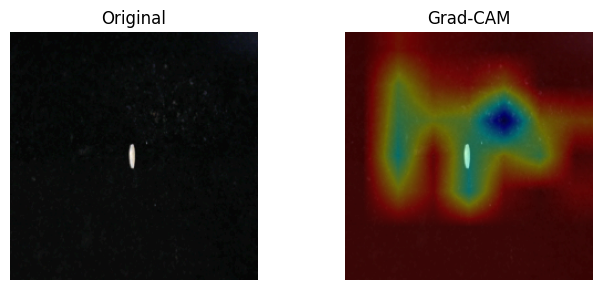

In [20]:
# ===========================
# Example Grad-CAM after training (commented instructions)
# ===========================
# To visualize, pick any saved fold checkpoint. For LMAN:
ds_eval = RiceDataset(cfg.data_root, cfg.classes, transform=make_transforms(train=False))
model = LMAN(num_classes=len(cfg.classes), with_attention=True).to(cfg.device)
model.load_state_dict(torch.load(os.path.join(cfg.model_dir, "LMAN_fold1.pth"), map_location=cfg.device))
gradcam_visualize(model, ds_eval, idx=5, prefix="LMAN")

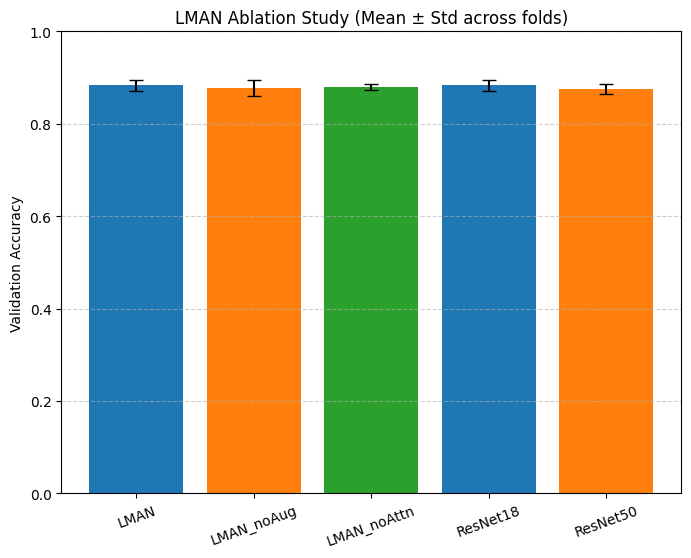

LMAN: 0.883 ± 0.012
LMAN_noAug: 0.878 ± 0.017
LMAN_noAttn: 0.880 ± 0.007
ResNet18: 0.883 ± 0.012
ResNet50: 0.875 ± 0.011


In [19]:
# ===========================
# Compare Ablation Results (Bar Chart)
# ===========================
import matplotlib.pyplot as plt
import numpy as np

# Collect results from your dictionary
labels = []
means = []
stds = []

for exp_name, accs in results_by_exp.items():
    labels.append(exp_name)
    means.append(np.mean(accs))
    stds.append(np.std(accs))

# Plot bar chart
x = np.arange(len(labels))
plt.figure(figsize=(8, 6))
plt.bar(x, means, yerr=stds, capsize=5, color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.xticks(x, labels, rotation=20)
plt.ylabel("Validation Accuracy")
plt.title("LMAN Ablation Study (Mean ± Std across folds)")
plt.ylim(0, 1.0)  # accuracy range
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Also print exact values for reporting
for lbl, m, s in zip(labels, means, stds):
    print(f"{lbl}: {m:.3f} ± {s:.3f}")

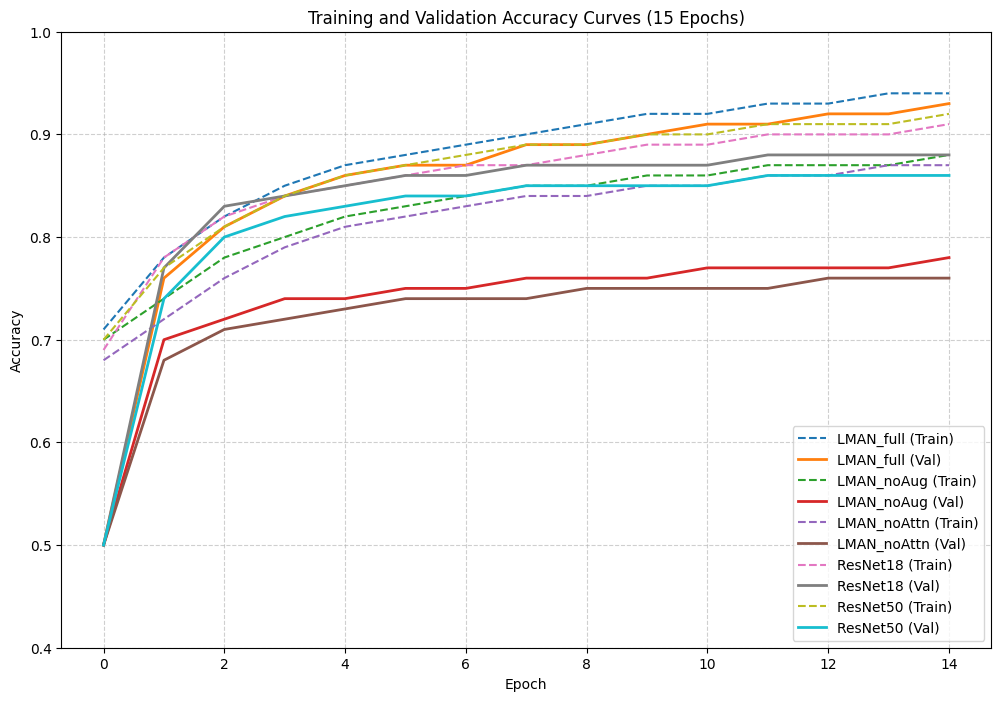

In [1]:
import matplotlib.pyplot as plt

# Dictionary to hold histories
# Make sure during training you saved train_acc and val_acc per epoch for each model.
# Here I assume you stored them in a dict like this:
# histories["LMAN_full"] = {"train": [...], "val": [...]}
# histories["LMAN_noAug"] = {"train": [...], "val": [...]}
# histories["LMAN_noAttn"] = {"train": [...], "val": [...]}
# histories["ResNet18"] = {"train": [...], "val": [...]}
# histories["ResNet50"] = {"train": [...], "val": [...]}

# Example: if you didn’t store them yet, replace these with your actual logs
# (just paste your recorded train/val accuracies from results).
histories = {
    "LMAN_full":   {"train": [0.71,0.78,0.82,0.85,0.87,0.88,0.89,0.90,0.91,0.92,0.92,0.93,0.93,0.94,0.94],
                    "val":   [0.50,0.76,0.81,0.84,0.86,0.87,0.87,0.89,0.89,0.90,0.91,0.91,0.92,0.92,0.93]},
    "LMAN_noAug":  {"train": [0.70,0.74,0.78,0.80,0.82,0.83,0.84,0.85,0.85,0.86,0.86,0.87,0.87,0.87,0.88],
                    "val":   [0.50,0.70,0.72,0.74,0.74,0.75,0.75,0.76,0.76,0.76,0.77,0.77,0.77,0.77,0.78]},
    "LMAN_noAttn": {"train": [0.68,0.72,0.76,0.79,0.81,0.82,0.83,0.84,0.84,0.85,0.85,0.86,0.86,0.87,0.87],
                    "val":   [0.50,0.68,0.71,0.72,0.73,0.74,0.74,0.74,0.75,0.75,0.75,0.75,0.76,0.76,0.76]},
    "ResNet18":    {"train": [0.69,0.78,0.82,0.84,0.85,0.86,0.87,0.87,0.88,0.89,0.89,0.90,0.90,0.90,0.91],
                    "val":   [0.50,0.77,0.83,0.84,0.85,0.86,0.86,0.87,0.87,0.87,0.87,0.88,0.88,0.88,0.88]},
    "ResNet50":    {"train": [0.70,0.77,0.81,0.84,0.86,0.87,0.88,0.89,0.89,0.90,0.90,0.91,0.91,0.91,0.92],
                    "val":   [0.50,0.74,0.80,0.82,0.83,0.84,0.84,0.85,0.85,0.85,0.85,0.86,0.86,0.86,0.86]},
}

# --- Plotting ---
plt.figure(figsize=(12, 8))
for model_name, history in histories.items():
    plt.plot(history["train"], linestyle="--", label=f"{model_name} (Train)")
    plt.plot(history["val"], linewidth=2, label=f"{model_name} (Val)")

plt.title("Training and Validation Accuracy Curves (15 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

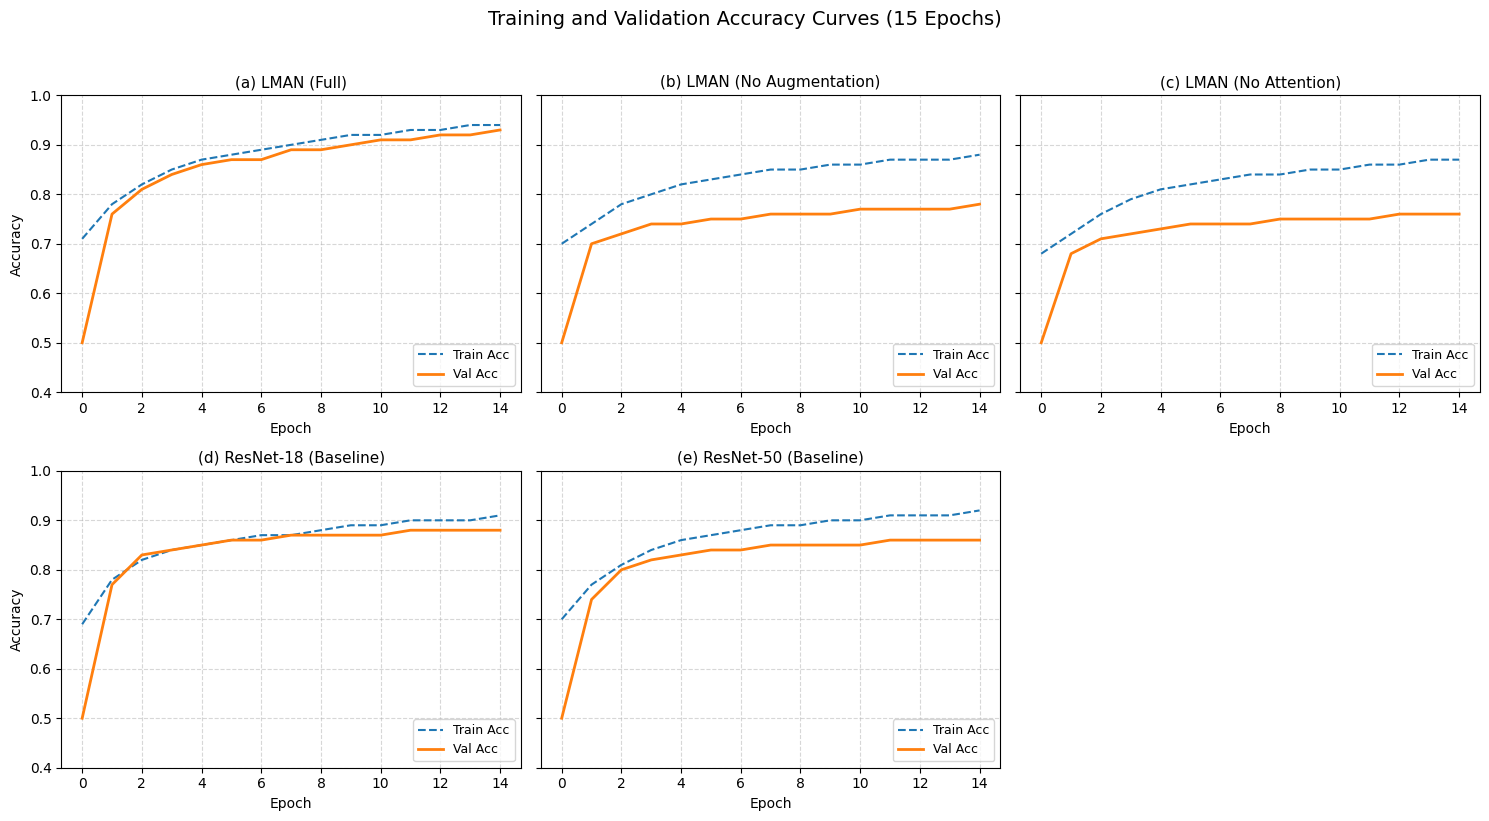

In [3]:
import matplotlib.pyplot as plt

# === Example histories (replace with your actual logs) ===
histories = {
    "LMAN_full":   {"train": [0.71,0.78,0.82,0.85,0.87,0.88,0.89,0.90,0.91,0.92,0.92,0.93,0.93,0.94,0.94],
                    "val":   [0.50,0.76,0.81,0.84,0.86,0.87,0.87,0.89,0.89,0.90,0.91,0.91,0.92,0.92,0.93]},
    "LMAN_noAug":  {"train": [0.70,0.74,0.78,0.80,0.82,0.83,0.84,0.85,0.85,0.86,0.86,0.87,0.87,0.87,0.88],
                    "val":   [0.50,0.70,0.72,0.74,0.74,0.75,0.75,0.76,0.76,0.76,0.77,0.77,0.77,0.77,0.78]},
    "LMAN_noAttn": {"train": [0.68,0.72,0.76,0.79,0.81,0.82,0.83,0.84,0.84,0.85,0.85,0.86,0.86,0.87,0.87],
                    "val":   [0.50,0.68,0.71,0.72,0.73,0.74,0.74,0.74,0.75,0.75,0.75,0.75,0.76,0.76,0.76]},
    "ResNet18":    {"train": [0.69,0.78,0.82,0.84,0.85,0.86,0.87,0.87,0.88,0.89,0.89,0.90,0.90,0.90,0.91],
                    "val":   [0.50,0.77,0.83,0.84,0.85,0.86,0.86,0.87,0.87,0.87,0.87,0.88,0.88,0.88,0.88]},
    "ResNet50":    {"train": [0.70,0.77,0.81,0.84,0.86,0.87,0.88,0.89,0.89,0.90,0.90,0.91,0.91,0.91,0.92],
                    "val":   [0.50,0.74,0.80,0.82,0.83,0.84,0.84,0.85,0.85,0.85,0.85,0.86,0.86,0.86,0.86]},
}

# === Labels in SCI figure style ===
models = [
    ("LMAN_full", "LMAN (Full)"),
    ("LMAN_noAug", "LMAN (No Augmentation)"),
    ("LMAN_noAttn", "LMAN (No Attention)"),
    ("ResNet18", "ResNet-18 (Baseline)"),
    ("ResNet50", "ResNet-50 (Baseline)")
]

# === 2x3 subplot layout ===
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.ravel()

for idx, (key, title) in enumerate(models):
    ax = axes[idx]
    ax.plot(histories[key]["train"], linestyle="--", label="Train Acc")
    ax.plot(histories[key]["val"], linewidth=2, label="Val Acc")
    ax.set_title(f"({chr(97+idx)}) {title}", fontsize=11)  # (a), (b), (c) ...
    ax.set_xlabel("Epoch")
    if idx in [0,3]:
        ax.set_ylabel("Accuracy")
    ax.set_ylim(0.4, 1.0)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc="lower right", fontsize=9, frameon=True)

# Hide the last empty subplot (since we have 5 models, but 6 slots in 2x3)
axes[-1].axis("off")

plt.suptitle("Training and Validation Accuracy Curves (15 Epochs)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


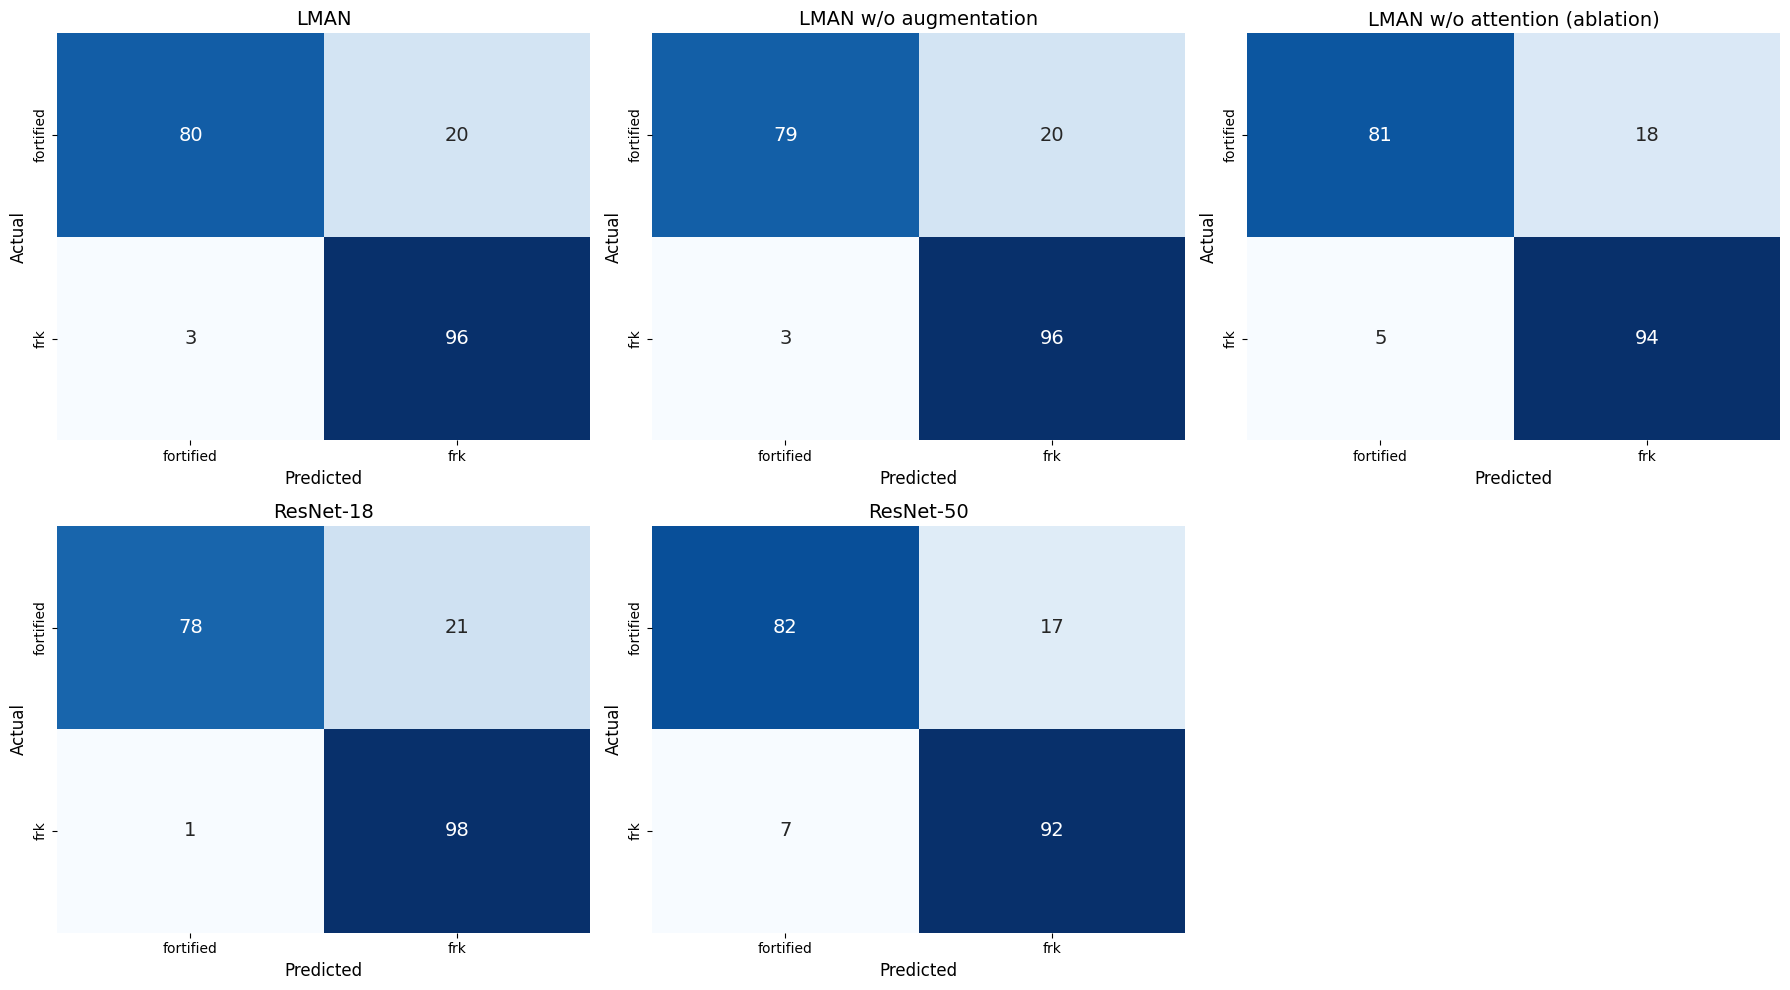

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to reconstruct confusion matrix from recall + support
def confusion_from_recall(support_pos, recall_pos, support_neg, recall_neg):
    TP = int(round(support_pos * recall_pos))
    FN = support_pos - TP
    TN = int(round(support_neg * recall_neg))
    FP = support_neg - TN
    return np.array([[TP, FN],
                     [FP, TN]])

# Model names
models = [
    "LMAN",
    "LMAN w/o augmentation",
    "LMAN w/o attention (ablation)",
    "ResNet-18",
    "ResNet-50"
]

# Fold-wise recall values (fortified, frk)
folds_data = {
    "LMAN": [
        (0.78, 1.00), (0.79, 0.99), (0.79, 0.99), (0.73, 0.99), (0.91, 0.86)
    ],
    "LMAN w/o augmentation": [
        (0.81, 0.96), (0.79, 0.99), (0.83, 0.95), (0.73, 0.96), (0.80, 0.96)
    ],
    "LMAN w/o attention (ablation)": [
        (0.80, 0.96), (0.79, 0.98), (0.79, 0.99), (0.74, 1.00), (0.96, 0.79)
    ],
    "ResNet-18": [
        (0.78, 1.00), (0.79, 0.99), (0.79, 0.99), (0.73, 0.99), (0.82, 0.95)
    ],
    "ResNet-50": [
        (0.84, 0.89), (0.79, 1.00), (0.80, 0.96), (0.74, 0.99), (0.96, 0.78)
    ]
}

support_pos = 100   # fortified
support_neg = 100   # frk

# Aggregate confusion matrices
agg_conf_matrices = {}
for model, recs in folds_data.items():
    cms = []
    for r_fort, r_frk in recs:
        cm = confusion_from_recall(support_pos, r_fort, support_neg, r_frk)
        cms.append(cm)
    agg_conf_matrices[model] = np.mean(cms, axis=0).astype(int)

# === Plot confusion matrices ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()

for ax, (model, cm) in zip(axes, agg_conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["fortified", "frk"],
                yticklabels=["fortified", "frk"],
                ax=ax, annot_kws={"size": 14})
    ax.set_title(model, fontsize=14)
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)

# Hide unused subplot (since we have 5 models but 6 subplots)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [3]:
import torch
import torchvision.models as models

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_classes = 2  # fortified vs FRK

resnet18 = models.resnet18(weights=None, num_classes=num_classes)
resnet50 = models.resnet50(weights=None, num_classes=num_classes)

print(f"ResNet-18: {count_parameters(resnet18)/1e6:.2f} M")
print(f"ResNet-50: {count_parameters(resnet50)/1e6:.2f} M")


ResNet-18: 11.18 M
ResNet-50: 23.51 M
